# Custom Optical Character Recongnition (OCR) Model with Tensorflow

I am using the dataset from kaggle. The dataset name is "Handwriting Recognition" by landlord, link to the dataset: [Handwriting Recognition](https://www.kaggle.com/datasets/landlord/handwriting-recognition).

Libraries Importing:
1. numpy
2. pandas
3. matplotlib
4. tensorflow
5. opencv

In [1]:
import string
import os
import shutil
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2 as cv
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

Global variables used throughout the notebook.

In [2]:
KAGGLE_DATASET_FOLDER = "/kaggle/input/handwriting-recognition"
MODEL_DATASET_DIR = "/kaggle/working/dataset"
TRAINING_DIR = "train"
TRAINING_CSV = "train.csv"
VALIDATION_DIR = "validation"
VALIDATION_CSV = "validation.csv"
TEST_DIR = "test"
TEST_CSV = "test.csv"
SAMPLE_PERCENTAGE = 0.05 # 50% of the overall data, To save overall run time
IMAGE_HEIGHT = 32
IMAGE_WIDTH=200
INPUT_NAME="FILENAME"
TARGET_NAME="IDENTITY"

all_characters = (string.ascii_letters + string.digits + string.punctuation)
all_characters = all_characters.replace("-", '')
all_characters = '-'+all_characters
list(all_characters)

VOCABULARY_SIZE = len(all_characters)
VOCABULARY_CHARACTERS = list(all_characters)

## Download dataset and move to working directory

Folder structure-
```
- handwritten-recognition
    - test_v2
        - test
            - TEST_0001.jpg
            - TEST_0002.jpg
            - ...
    - train_v2
          - train
            - TRAIN_0001.jpg
            - TRAIN_0002.jpg
            - ...
    - validation_v2
        - validation
            - VALIDATION_0001.jpg
            - VALIDATION_0002.jpg
            - ...
    - written_name_test_v2.csv
    - written_name_train_v2.csv
    - written_name_validation_v2.csv
```

`written_name_train_v2.csv` file contains the file name to identity mapping, mapping here means the words written in the image. Same is true for `written_name_test_v2.csv` & `written_name_validation_v2.csv`.

Column names are `FILENAME` & `IDENTITY`.

Make directories for dataset to store the train, test and validation data.

In [3]:
os.makedirs(os.path.join(MODEL_DATASET_DIR, TRAINING_DIR))
os.makedirs(os.path.join(MODEL_DATASET_DIR, VALIDATION_DIR))
os.makedirs(os.path.join(MODEL_DATASET_DIR, TEST_DIR))

Copy the csv files from original dataset to the working dataset directory.

In [4]:
shutil.copy(os.path.join(KAGGLE_DATASET_FOLDER, "written_name_train_v2.csv"), os.path.join(MODEL_DATASET_DIR, TRAINING_CSV))
shutil.copy(os.path.join(KAGGLE_DATASET_FOLDER, "written_name_validation_v2.csv"), os.path.join(MODEL_DATASET_DIR, VALIDATION_CSV))
shutil.copy(os.path.join(KAGGLE_DATASET_FOLDER, "written_name_test_v2.csv"), os.path.join(MODEL_DATASET_DIR, TEST_CSV))

'/kaggle/working/dataset/test.csv'

In [5]:
# Train data & sampling
train_df = pd.read_csv(os.path.join(MODEL_DATASET_DIR, TRAINING_CSV))
total_train_size = train_df.shape[0]
sample_train_size = int(total_train_size * SAMPLE_PERCENTAGE)
print(f"Total training data size: {total_train_size}")
print(f"Sample training data size: {sample_train_size}")

# Validation data & sampling
validation_df = pd.read_csv(os.path.join(MODEL_DATASET_DIR, VALIDATION_CSV))
total_validation_size = validation_df.shape[0]
sample_validation_size = int(total_validation_size * SAMPLE_PERCENTAGE)
print(f"Total validation data size: {total_validation_size}")
print(f"Sample validation data size: {sample_validation_size}")

# Test data & sampling
test_df = pd.read_csv(os.path.join(MODEL_DATASET_DIR, TEST_CSV))
total_test_size = test_df.shape[0]
sample_test_size = int(total_test_size * SAMPLE_PERCENTAGE)
print(f"Total test data size: {total_test_size}")
print(f"Sample test data size: {sample_test_size}")

Total training data size: 330961
Sample training data size: 16548
Total validation data size: 41370
Sample validation data size: 2068
Total test data size: 41370
Sample test data size: 2068


Copy the images with the help of csv files as they have all the image names.

In [6]:
def copy_from_to(csv_file, from_dir, to_dir, sample_n_rows=1000):
    df = pd.read_csv(csv_file, nrows=sample_n_rows)
    copy_func = lambda x: shutil.copy2(os.path.join(from_dir, x), to_dir)
    df['FILENAME'].apply(copy_func)

In [7]:
# Copy training images from kaggle dataset to working dataset
train_csv_file_path = os.path.join(MODEL_DATASET_DIR, TRAINING_CSV)
src_training_images_dir = os.path.join(KAGGLE_DATASET_FOLDER, "train_v2/train")
dest_training_images_dir = os.path.join(MODEL_DATASET_DIR, TRAINING_DIR)
copy_from_to(train_csv_file_path, 
             src_training_images_dir, 
             dest_training_images_dir, 
             sample_n_rows=sample_train_size)

# Copy validation images from kaggle dataset to working dataset
validation_csv_file_path = os.path.join(MODEL_DATASET_DIR, VALIDATION_CSV)
src_validation_images_dir = os.path.join(KAGGLE_DATASET_FOLDER, "validation_v2/validation")
dest_validation_images_dir = os.path.join(MODEL_DATASET_DIR, VALIDATION_DIR)
copy_from_to(validation_csv_file_path, 
                            src_validation_images_dir, 
                            dest_validation_images_dir, 
                            sample_n_rows=sample_validation_size)

# Copy test images from kaggle dataset to working dataset
test_csv_file_path = os.path.join(MODEL_DATASET_DIR, TEST_CSV)
src_test_images_dir = os.path.join(KAGGLE_DATASET_FOLDER, "test_v2/test")
dest_test_images_dir = os.path.join(MODEL_DATASET_DIR, TEST_DIR)
copy_from_to(test_csv_file_path, 
             src_test_images_dir, 
             dest_test_images_dir, 
             sample_n_rows=sample_test_size)

## Model - Recurrent Convolutional Neural Network

CRNN has 3 layers from bottom to top -
1. Convolution Layer - Extract a feature sequence from each input image
2. Recurrent Layer - Make prediction for each frame of the feature sequence
3. Transcription Layer - Translate per-frame prediction from recurrent layer into a label sequence

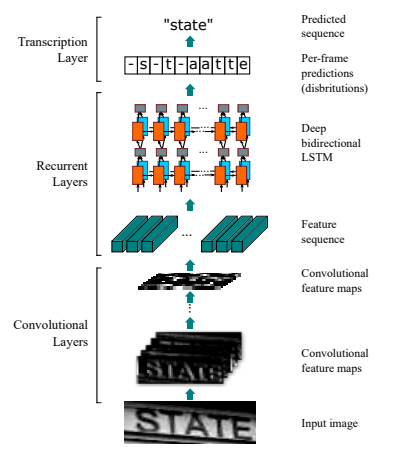

Source: [An End-to-End Trainable Neural Network for Image-based Sequence 
Recognition and Its Application to Scene Text Recognition](https://arxiv.org/pdf/1507.05717)

### Convolution Layer

CNN components without the feed-forward network layers in used to extract the feature sequence from the image.

Before passing to the network, we need to scale all the images to same height. Then a sequence of feature vectors is extracted from the feature maps produced by the component of the convolution layer.

Specifically, each feature vector of a feature 
sequence is generated from left to right on the feature map 
by column. This means the i-th feature vector is the concatenation of the i-th columns of all the maps. The width  f
each column theour settings is fixed to single pix

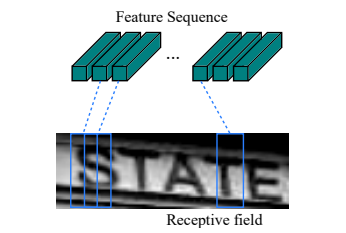

As the layers of convolution, max-pooling, and elementwise activation function operate on local regions, they are translation invariant. Therefore, each column of the feature maps corresponds to a rectangle region of the original image (termed the receptive field), and such rectangle regions are in the same order to their corresponding columns on the feature maps from left to right. Each vector in the feature sequence is associated with a receptive field, and can be considered as the image descriptor for that region.ion.m-el.

In [8]:
class ConvLayer(keras.Model):
    def __init__(self, image_height, image_width, name="ConvLayer", **kwargs):
        super().__init__(name=name, **kwargs)
        
        self.rescale = layers.Rescaling(1./255, input_shape=(image_height, image_width, 3))
        self.conv_1 = layers.Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding="same", activation="relu")
        self.pooling_1 = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))
        self.conv_2 = layers.Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), padding="same", activation="relu")
        self.pooling_2 = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))
        self.conv_3 = layers.Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), padding="same", activation="relu")
        self.conv_4 = layers.Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), padding="same", activation="relu")
        self.pooling_3 = layers.MaxPooling2D(pool_size=(1, 2), strides=(1, 2))
        self.conv_5 = layers.Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), padding="same", activation="relu")
        self.batch_norm_1 = layers.BatchNormalization()
        self.conv_6 = layers.Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), padding="same", activation="relu")
        self.batch_norm_2 = layers.BatchNormalization()
        self.pooling_4 = layers.MaxPooling2D(pool_size=(1, 2), strides=(1, 2))
        self.conv_7 = layers.Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), activation="relu")
    
    def call(self, input_tensor, training=False):
        x = self.rescale(input_tensor)
        x = self.conv_1(x)
        x = self.pooling_1(x)
        x = self.conv_2(x)
        x = self.pooling_2(x)
        x = self.conv_3(x)
        x = self.conv_4(x)
        x = self.pooling_3(x)
        x = self.conv_5(x)
        x = self.batch_norm_1(x, training=training)
        x = self.conv_6(x)
        x = self.batch_norm_2(x, training=training)
        x = self.pooling_4(x)
        x = self.conv_7(x)
        
        batch, height, width, depth = tf.shape(x)[0], tf.shape(x)[1], tf.shape(x)[2], tf.shape(x)[3]
        x = tf.reshape(x, [batch, width, height*depth])
        return x


### Recurrent Layer

A deep bidirectional neural net to work as recurrent layer on top of the convolutional layer taking the feature sequence $X = x_1, x_2, ..., x_t, ..., x_T$.

RNN are good at understanding sequence data and predicting the data based on the previous learnt context, especially LSTM which are improvement over normal RNN that memorizes context that came a lot before.

In this implementation, we are using 2 layers of bidirectional LSTM. The reason for using RNN is that they back-propagate the errors through input layer which in this case is convolutional layer and makes the whole network trainable with only one loss function.

In [9]:
class RecurrentLayer(keras.Model):
    def __init__(self, vocab_size, name="RecurrentLayer", **kwargs):
        super().__init__(name=name, **kwargs)
        self.lstm_1 = layers.Bidirectional(layers.LSTM(256, return_sequences=True, return_state=False))
        self.lstm_2 = layers.Bidirectional(layers.LSTM(256, return_sequences=True, return_state=False))
        self.dense = layers.Dense(vocab_size)
    
    def call(self, input_tensor, training=False):
        x = self.lstm_1(input_tensor, training=training)
        x = self.lstm_2(x, training=training)
        x = self.dense(x, training=training)
        
        return x

In [10]:
class OCRModel(keras.Model):
    def __init__(self, image_height, image_width, vocab_size, name="OCRModel", **kwargs):
        super().__init__(name=name, **kwargs)
        
        self.cn_layer = ConvLayer(image_height, image_width)
        self.rn_layer = RecurrentLayer(vocab_size)
        
    def call(self, inputs):
        x = self.cn_layer(inputs)
        x = self.rn_layer(x)
        
        return x

Preparing sample examples to check the layer output

In [11]:
train_df = pd.read_csv(train_csv_file_path, nrows=sample_train_size)
train_df.shape

(16548, 2)

In [12]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16548 entries, 0 to 16547
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   FILENAME  16548 non-null  object
 1   IDENTITY  16523 non-null  object
dtypes: object(2)
memory usage: 258.7+ KB


In [13]:
train_df[TARGET_NAME].isnull().sum()

25

25 null entries in the target column.

In [14]:
train_df[train_df[TARGET_NAME].isnull()]

,FILENAME,IDENTITY
1913,TRAIN_01914.jpg,NaN
2129,TRAIN_02130.jpg,NaN
2624,TRAIN_02625.jpg,NaN
4628,TRAIN_04629.jpg,NaN
4872,TRAIN_04873.jpg,NaN
6991,TRAIN_06992.jpg,NaN
7252,TRAIN_07253.jpg,NaN
9100,TRAIN_09101.jpg,NaN
9197,TRAIN_09198.jpg,NaN
9381,TRAIN_09382.jpg,NaN


Let's take one of these images and see what they contain.

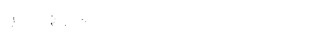

In [15]:
img_name = "TRAIN_01914.jpg"
img_fullpath = os.path.join(MODEL_DATASET_DIR, TRAINING_DIR, img_name)
Image.open(img_fullpath)

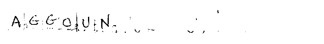

In [16]:
img_name = "TRAIN_02130.jpg"
img_fullpath = os.path.join(MODEL_DATASET_DIR, TRAINING_DIR, img_name)
Image.open(img_fullpath)

In [17]:
img_name = "TRAIN_09903.jpg"
img_fullpath = os.path.join(MODEL_DATASET_DIR, TRAINING_DIR, img_name)
Image.open(img_fullpath)

While some of the images contain nothing, some other contain something but not totally visible in the image.

So, the best choice here is to remove these entries from the images to avoid discrepencies in the training as the images are not clear.

In [18]:
train_df = train_df[~train_df[TARGET_NAME].isnull()]
train_df.shape

(16523, 2)

We can do the same with validation as well as test. Let's write the whole concept for train, validation and test all at once.

When I am working on it, I am also going to replace image filenames with their full path so that when creating dataset we can easily do it.

In [19]:
max_sequence_length = train_df[TARGET_NAME].map(lambda x: len(x)).max()
max_sequence_length

24

In [20]:
def get_full_image_path(filename):
    filepath = os.path.join(MODEL_DATASET_DIR, TRAINING_DIR, filename)
    return filepath

lookup_method = tf.keras.layers.StringLookup(
    vocabulary=list(VOCABULARY_CHARACTERS), 
    mask_token=None, 
)
def lookup(text):
    chars = tf.strings.unicode_split(text, input_encoding="UTF-8")
    # Pad the string characters till maimum sequence before lookup to get same shape
    chars = tf.pad(chars, 
                  paddings=[[0, max_sequence_length-tf.shape(chars)[0]]], 
                  constant_values="")
    ids_from_chars = lookup_method(chars)
    return ids_from_chars

def decode_img(img):
    img = tf.io.decode_jpeg(img, channels=3)
    return tf.image.resize(img, [IMAGE_HEIGHT, 200])

def get_img_label(filepath, label):
    label = lookup(label)
    img = tf.io.read_file(filepath)
    img = decode_img(img)
    return img, label

In [21]:
# Cleaning dataframes
train_df = pd.read_csv(train_csv_file_path, nrows=sample_train_size)
train_df = train_df[~train_df[TARGET_NAME].isnull()]
train_df[INPUT_NAME] = train_df[INPUT_NAME].apply(get_full_image_path)

validation_df = pd.read_csv(validation_csv_file_path, nrows=sample_validation_size)
validation_df = validation_df[~validation_df[TARGET_NAME].isnull()]
validation_df[INPUT_NAME] = validation_df[INPUT_NAME].apply(get_full_image_path)

test_df = pd.read_csv(test_csv_file_path, nrows=sample_test_size)
test_df = test_df[~test_df[TARGET_NAME].isnull()]
test_df[INPUT_NAME] = test_df[INPUT_NAME].apply(get_full_image_path)


# Creating datasets from lists
train_ds = tf.data.Dataset.from_tensor_slices((train_df[INPUT_NAME], 
                                               train_df[TARGET_NAME]))
validation_ds = tf.data.Dataset.from_tensor_slices((validation_df[INPUT_NAME], 
                                                    validation_df[TARGET_NAME]))
test_ds = tf.data.Dataset.from_tensor_slices((test_df[INPUT_NAME], 
                                              test_df[TARGET_NAME]))

# Get the images and label sequence
train_ds = train_ds.map(lambda path, label: get_img_label(path, label))
validation_ds = validation_ds.map(lambda path, label: get_img_label(path, label))
test_ds = test_ds.map(lambda path, label: get_img_label(path, label,))

# Batch the data
train_ds = train_ds.batch(batch_size=32)
validation_ds = validation_ds.batch(batch_size=16)
test_ds = test_ds.batch(batch_size=16)

In [23]:
for sample_imgs, sample_labels in train_ds.take(1):
    print(sample_imgs.shape) # (batch, height, width, channel)
    print(sample_labels.shape) # (batch, max_sequence_length)

(32, 32, 200, 3)
(32, 24)


Checking the layer output

In [24]:
conv_layer = ConvLayer(image_height=IMAGE_HEIGHT, image_width=IMAGE_WIDTH)
conv_layer_output =  conv_layer(sample_imgs)
conv_layer_output.shape

/opt/conda/lib/python3.10/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:18: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


TensorShape([32, 10, 3072])

In [25]:
recurrent_layer = RecurrentLayer(vocab_size=100)
recurrent_layer_output = recurrent_layer(conv_layer_output)
recurrent_layer_output.shape

TensorShape([32, 10, 100])

In [26]:
class CustomSparseCategoricalCrossentropy(keras.Loss):
    def __init__(self, from_logits=False):
        super(CustomSparseCategoricalCrossentropy, self).__init__()
        self.loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=from_logits)
        
    def call(self, y_true, y_pred, sample_weight=None):
        y_true_length = tf.shape(y_true)[1]
        y_pred_length = tf.shape(y_pred)[1]
        
        y_pred = tf.cond(
            y_pred_length < y_true_length,
            lambda: tf.pad(y_pred, paddings=[[0, 0], [0, y_true_length - y_pred_length], [0, 0]]),
            lambda: y_pred[:, :y_true_length, :]  # Slice if y_pred is longer
        )
        
        return self.loss_fn(y_true, y_pred, sample_weight=sample_weight)

In [28]:
loss = CustomSparseCategoricalCrossentropy(from_logits=True)
loss(sample_labels, recurrent_layer_output)

<tf.Tensor: shape=(), dtype=float32, numpy=4.606209>

Prepare training dataset

In [29]:
model = OCRModel(IMAGE_HEIGHT, IMAGE_WIDTH, VOCABULARY_SIZE)
sample_model_output = model(sample_imgs)
print(f"Model output shape: {sample_model_output.shape}")
model.summary()

Model output shape: (32, 10, 94)


Model: "OCRModel"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ ConvLayer (ConvLayer)           │ ?                      │     6,864,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ RecurrentLayer (RecurrentLayer) │ ?                      │     8,440,926 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,305,694 (58.39 MB)

 Trainable params: 15,303,646 (58.38 MB)

 Non-trainable params: 2,048 (8.00 KB)

In [31]:
model.compile(loss=CustomSparseCategoricalCrossentropy(from_logits=True), 
             optimizer=keras.optimizers.Adam(), 
             metrics=["accuracy"])
model.fit(train_ds, 
          validation_data=validation_ds, 
          epochs=1, 
          steps_per_epoch=10)

InvalidArgumentError: Graph execution error:

Detected at node Equal defined at (most recent call last):
  File "/opt/conda/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/opt/conda/lib/python3.10/runpy.py", line 86, in _run_code

  File "/opt/conda/lib/python3.10/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/opt/conda/lib/python3.10/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/opt/conda/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/opt/conda/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/opt/conda/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/opt/conda/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue

  File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 534, in process_one

  File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/opt/conda/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 362, in execute_request

  File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 778, in execute_request

  File "/opt/conda/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 449, in do_execute

  File "/opt/conda/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3051, in run_cell

  File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3106, in _run_cell

  File "/opt/conda/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3311, in run_cell_async

  File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3493, in run_ast_nodes

  File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "/tmp/ipykernel_30/514457791.py", line 4, in <module>

  File "/opt/conda/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/opt/conda/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 314, in fit

  File "/opt/conda/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 117, in one_step_on_iterator

  File "/opt/conda/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 104, in one_step_on_data

  File "/opt/conda/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 73, in train_step

  File "/opt/conda/lib/python3.10/site-packages/keras/src/trainers/trainer.py", line 412, in compute_metrics

  File "/opt/conda/lib/python3.10/site-packages/keras/src/trainers/compile_utils.py", line 330, in update_state

  File "/opt/conda/lib/python3.10/site-packages/keras/src/trainers/compile_utils.py", line 17, in update_state

  File "/opt/conda/lib/python3.10/site-packages/keras/src/metrics/reduction_metrics.py", line 202, in update_state

  File "/opt/conda/lib/python3.10/site-packages/keras/src/metrics/accuracy_metrics.py", line 252, in sparse_categorical_accuracy

  File "/opt/conda/lib/python3.10/site-packages/keras/src/ops/numpy.py", line 2355, in equal

  File "/opt/conda/lib/python3.10/site-packages/keras/src/backend/tensorflow/numpy.py", line 1131, in equal

Incompatible shapes: [32,24] vs. [32,10]
	 [[{{node Equal}}]] [Op:__inference_one_step_on_iterator_16872]

### Transcription Layer

Transcription is the process of converting the per-frame predictions made by RNN to label sequence. Mathematically, transcription is the process of finding highest probable label sequence conditioned on the per-frame predictions.

There are two methods for transcription - lexicon free and lexicon based.

Lexicon is a label sequence that the prediction is constraint to e.g. a spell checking dictionary.

In lexicon free transcription, the output label sequence is generated with the following equation-
$$
l^* = \beta(argmax_{\pi}p(\pi|y))
$$

$\beta$ - mapping from RNN predictions to label sequence after removing blanks(`-`) and repetetive characters. E.g. $\beta(`--hh-e-l-ll-oo--`)$ -> `hello`

In lexicon based transcription, we find the lexicon that is highest probable based on the predicted label sequence - $l^*=argmax_{l \in D}(p(l|y))$ where `D` is all lexicons possible.

For a bigger dictionary, doing the above operation is time consuming, so instead of looking into all possible lexicons, we only look into lexicons that are closest to the label sequence coming from lexicon free transcription.

The following is the updated rule- 
$$
l^*=argmax_{l \in N_\delta(l')}p(l|y)
$$

where $N_\delta(l')$ are the nearest-neighbour lexicons that has an edit distance of $\delta$ from the lexicon free transcription output `l'`

The candidate $N_\delta(l')$ can be found easily by BK-Tree algorithm.